The goal of this notebook is the development of a workflow for manual curation of Mass2Motifs. The 3 major characteristics investigated for each motif are:
- Chemical similarity of the annotated structures from Spec2Vec
- Chemical consistency of the substructure regarding the spectra that contain the motif
- Spectral coverage of the motif and peak consistency of the fragments that define the Mass2Motif

In [1]:
from MS2LDA.motif_parser import load_m2m_folder
from MS2LDA.Add_On.MassQL.MassQL4MotifDB import load_motifDB, motifDB2motifs
from MS2LDA.utils import retrieve_spec4doc

from MS2LDA.Add_On.Fingerprints.FP_annotation import annotate_motifs as calc_fingerprints

import pickle
import tomotopy as tp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text

from rdkit import Chem
import numpy as np
from tqdm import tqdm
from rdkit import DataStructs
from rdkit.DataStructs.cDataStructs import ExplicitBitVect
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem import MolFromSmiles
from rdkit.Chem import MolFromSmarts


from typing import Dict, List, Optional
from rdkit.Chem import MolFromSmiles, rdFMCS, RDKFingerprint
from rdkit.DataStructs import TanimotoSimilarity
from tqdm import tqdm

from collections import defaultdict
from matchms import calculate_scores
from matchms import Spectrum
from matchms.similarity import CosineGreedy


from rdkit.Chem import Draw


Each MS2LDA run afterwards has already gone through the second filtering step from the process_motif function. The results of this function were saved in a pickle file, which gets loaded here.

In [2]:
def load_run(path):
    with open(path, "rb") as f:
        cache = pickle.load(f)
    return cache["results_sos"], cache["motif_to_docs"]

In [3]:
motifDB_1, motifDB_2 = load_motifDB("/home/ioannis/thesis_data/negative_test_results_filtered/motifset_optimized.json")
motifs = motifDB2motifs(motifDB_2)
with open('/home/ioannis/thesis_data/negative_test_results_filtered/doc2spec_map.pkl', 'rb') as f:
    doc2spec_map = pickle.load(f)
lda_model = tp.LDAModel.load('/home/ioannis/thesis_data/negative_test_results_filtered/ms2lda.bin')

In [4]:
results_sos, motif_to_docs = load_run("/home/ioannis/thesis_data/negative_test_results_filtered/motif_cache.pkl")

In [5]:
print(len(results_sos['motif_ids']))

128


In [6]:
print(results_sos)

{'motif_ids': [162, 61, 26, 69, 58, 77, 116, 159, 139, 100, 66, 18, 5, 43, 72, 59, 142, 121, 152, 111, 46, 11, 123, 192, 115, 114, 130, 141, 195, 48, 147, 81, 35, 163, 170, 50, 98, 7, 99, 173, 16, 193, 90, 20, 180, 169, 29, 23, 101, 15, 42, 39, 134, 45, 10, 74, 104, 67, 94, 40, 56, 182, 151, 124, 166, 28, 24, 158, 87, 105, 88, 2, 83, 13, 49, 63, 185, 153, 178, 108, 6, 52, 33, 12, 131, 80, 79, 128, 148, 122, 194, 71, 191, 175, 75, 14, 21, 172, 97, 37, 65, 36, 96, 57, 161, 86, 106, 190, 188, 199, 76, 150, 85, 17, 118, 189, 84, 129, 138, 198, 38, 89, 113, 164, 8, 174, 62, 68], 'num_atoms': [13, 6, 6, 6, 3, 6, 2, 4, 9, 6, 7, 6, 8, 2, 22, 10, 6, 14, 5, 7, 3, 2, 7, 3, 6, 5, 6, 7, 1, 2, 6, 3, 7, 6, 3, 8, 9, 0, 6, 7, 12, 1, 4, 10, 12, 7, 1, 12, 7, 2, 0, 7, 7, 17, 6, 7, 17, 4, 2, 31, 1, 14, 8, 1, 3, 3, 7, 31, 6, 6, 6, 2, 37, 2, 12, 12, 6, 42, 2, 9, 2, 1, 1, 9, 11, 6, 3, 1, 6, 2, 3, 8, 6, 6, 7, 2, 6, 6, 7, 6, 19, 6, 2, 4, 6, 2, 11, 4, 8, 1, 2, 13, 12, 7, 9, 3, 6, 6, 6, 6, 9, 6, 7, 3, 10, 5, 2, 2

In [7]:
motif_summary = {
    motif_id: {
        "intra": results_sos["intra_sims"][i],
        "inter": results_sos["inter_sims"][i],
        "mcs_size": results_sos["num_atoms"][i],
        "n_features": results_sos["len_frag_loss"][i],
    }
    for i, motif_id in enumerate(results_sos["motif_ids"])
}

In [8]:
def print_motif_summary(motif_id):
    if motif_id not in motif_summary:
        print(f"Motif {motif_id} not found in this run.")
        return
    
    info = motif_summary[motif_id]
    print(f"\n=== Summary for Motif {motif_id} ===")
    print(f"  Intra similarity   : {info['intra']:.3f}")
    print(f"  Inter similarity   : {info['inter']:.3f}")
    print(f"  MCS size (atoms)   : {info['mcs_size']}")
    print(f"  n_features (peaks) : {info['n_features']}")


In [77]:
motif_id = 180
print_motif_summary(motif_id)


=== Summary for Motif 180 ===
  Intra similarity   : 0.243
  Inter similarity   : 0.249
  MCS size (atoms)   : 12
  n_features (peaks) : 2


In [49]:
def plot_mcs(smarts):
    m = Chem.MolFromSmarts(smarts)
    if m is None:
        print("Could not parse SMARTS")
        return
    display(Draw.MolToImage(m, size=(300, 300)))



With the plot below provided, the visualization of the mcs is easier. MCS is derived from the auto annotations from Spec2Vec.

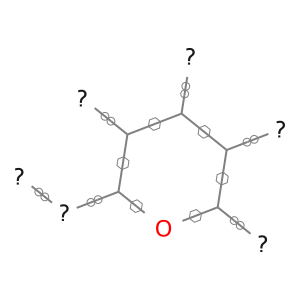

In [78]:
idx = results_sos["motif_ids"].index(motif_id)
smarts = results_sos["mcs_smarts"][idx]

plot_mcs(smarts)


The next step is to visualize the molecules coming from the spectra that contain this motif, in order to be able to see if these spectra also contain the substructure. Below, the first plot shows molecules coming just from 12 spectra that have the motif, the plot below shows the overlap of the mcs with the molecules of all the candidate spectra.

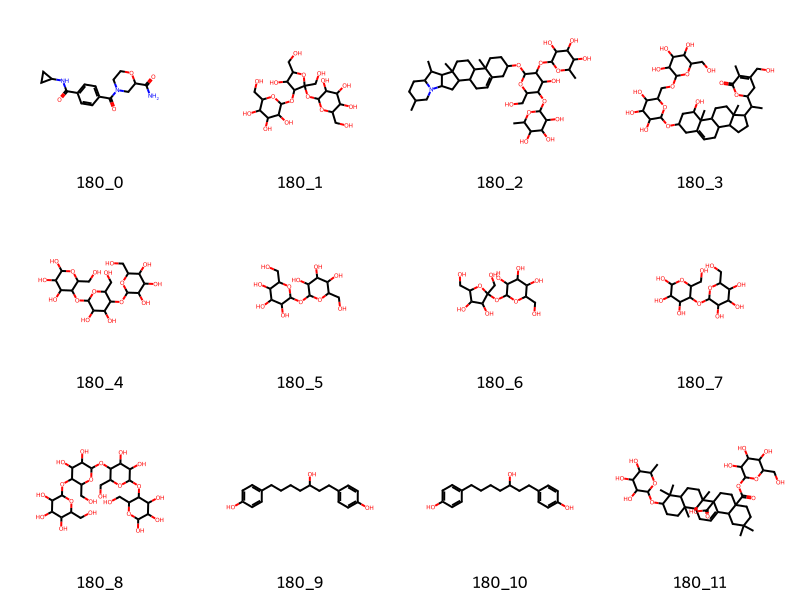

In [79]:
def show_motif_molecules(results, motif_id, max_mols=12):
    mols = results["molecules_by_motif"][motif_id][:max_mols]
    legends = [f"{motif_id}_{i}" for i in range(len(mols))]
    img = Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(200, 200), legends=legends)
    display(img)

show_motif_molecules(results_sos, motif_id)


In [80]:
mcs_query = Chem.MolFromSmarts(smarts)
highlighted = []
for mol in results_sos["molecules_by_motif"][motif_id]:
    match = mol.GetSubstructMatch(mcs_query)
    highlighted.append(match)


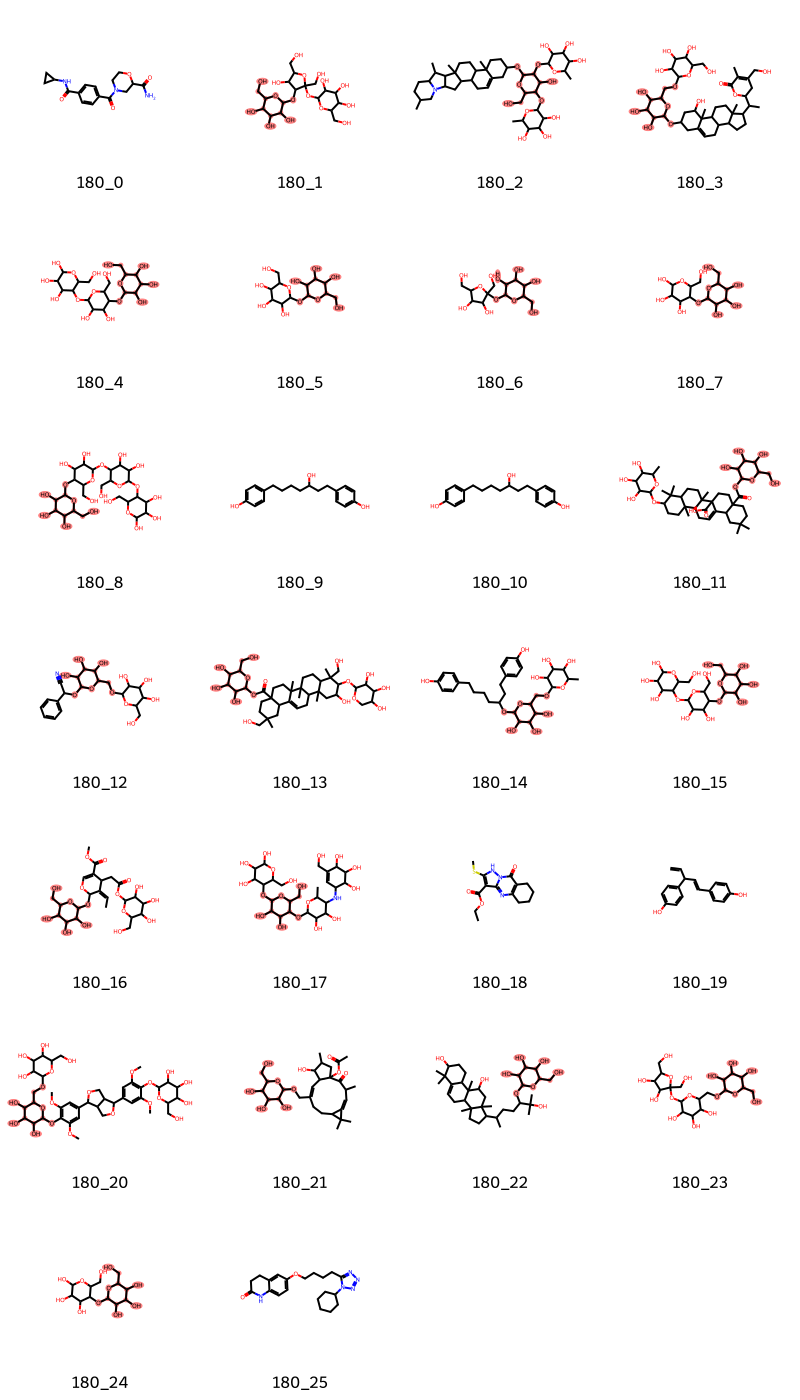

In [81]:
mols = results_sos["molecules_by_motif"][motif_id]
legends = [f"{motif_id}_{i}" for i in range(len(mols))]
img = Draw.MolsToGridImage( mols, molsPerRow=4, subImgSize=(200, 200), legends=legends, highlightAtomLists=highlighted ) 
display(img) 


In order to ensure chemical consistency among the candidate spectra, the fraction of molecules where the MCS is actually present is calculated. The term used for this fraction is "mcs support".

In [28]:
def compute_mcs_support(results, motif_id):
    """Return fraction of molecules where the MCS is actually present."""
    
    # Get the SMARTS for this motif
    idx = results["motif_ids"].index(motif_id)
    smarts = results["mcs_smarts"][idx]
    mcs_query = Chem.MolFromSmarts(smarts)
    
    # Get candidate molecules
    mols = results["molecules_by_motif"][motif_id]
    total = len(mols)
    
    # Count how many contain the MCS
    support = 0
    for mol in mols:
        if mol.HasSubstructMatch(mcs_query):
            support += 1
    
    return support / total if total > 0 else 0.0


In [82]:
support_fraction = compute_mcs_support(results_sos, motif_id)
print(f"MCS support for motif {motif_id}: {support_fraction:.3f}")


MCS support for motif 180: 0.769


In [55]:
mols = results_sos["molecules_by_motif"][motif_id]
unique_smiles = set(Chem.MolToSmiles(m) for m in mols)
print("Unique molecules:", len(unique_smiles))


Unique molecules: 18


In [39]:
print(smarts)

[#6]1:&@[#6](-&!@[#8&!R]):&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1-&!@[#8&!R]


Now the next step, is to check the motif spectrally. And also check the consistency of each motif across the spectra that contain it.

In [ ]:
def get_spectrum(doc_id):
    """
    Retrieve the m/z and intensity arrays for a given document ID.

    Parameters
    ----------
    doc_id : int
        Identifier of the document/spectrum to retrieve from motif_to_docs.

    Returns
    -------
    tuple of np.ndarray
        Two arrays: (mzs, intensities) extracted from the MatchMS Spectrum.
    """
    spec = retrieve_spec4doc(doc2spec_map, lda_model, doc_id)
    return np.array(spec.peaks.mz), np.array(spec.peaks.intensities)



def peak_present(mz_array, target, tol=0.01):
    """
    Check whether a target m/z value is present within ±tol of any peak.

    Parameters
    ----------
    mz_array : array-like
        Array of m/z values from a spectrum.
    target : float
        The motif peak m/z to search for.
    tol : float, optional
        Absolute tolerance window for matching (default 0.01).

    Returns
    -------
    bool
        True if a peak within the tolerance is found, otherwise False.
    """
    return np.any(np.abs(mz_array - target) <= tol)



def get_motif_peaks(motif_id):
    """
    Return the list of m/z peaks associated with a given motif.

    Parameters
    ----------
    motif_id : int
        Numeric motif identifier (matching the suffix of 'motif_X').

    Returns
    -------
    list of float
        The motif's characteristic m/z peak values.

    Raises
    ------
    ValueError
        If the motif ID does not exist in the loaded motif list.
    """
    for m in motifs:
        if int(m.get("id").split("_")[1]) == motif_id:
            return list(m.peaks.mz)
    raise ValueError(f"Motif {motif_id} not found.")


In [ ]:
def check_motif(motif_id, tol=0.01):
    """
    Compute and display spectral reproducibility statistics for a given motif.

    Parameters
    ----------
    motif_id : int
        Identifier of the motif to evaluate. Must exist in both
        `motif_to_docs` and the peak lookup used by `get_motif_peaks`.
    tol : float, optional
        Absolute m/z tolerance used when checking whether a motif peak is
        present in a spectrum. Default is 0.01.

    Returns
    -------
    dict
        A dictionary containing structured reproducibility information:
        - ``motif_id`` : the motif identifier
        - ``peaks`` : list of motif peak m/z values
        - ``n_spectra`` : number of spectra containing the motif
        - ``peak_counts`` : list with counts of spectra where each peak is present
        - ``both_count`` : number of spectra where all motif peaks co-occur
        - ``peak_fractions`` : per-peak reproducibility fractions
        - ``both_fraction`` : fraction of spectra where all peaks co-occur
    """

    
    # Get motif peaks
    peaks = get_motif_peaks(motif_id)
    print(f"\n=== Motif {motif_id} ===")
    print(f"Motif peaks: {peaks}")
    
    # Get documents/spectra where motif is active
    if motif_id not in motif_to_docs:
        print("No spectra contain this motif above the probability threshold.")
        return
    
    docs = motif_to_docs[motif_id]
    print(f"Spectra containing motif {motif_id}: {len(docs)}")
    
    # Check peak presence
    presence_matrix = []
    for doc_id in docs:
        mzs, ints = get_spectrum(doc_id)
        presence = [peak_present(mzs, p, tol) for p in peaks]
        presence_matrix.append(presence)
    
    # Summaries
    n = len(docs)
    peak_counts = [sum(row[i] for row in presence_matrix) for i in range(len(peaks))]
    both_count = sum(all(row) for row in presence_matrix)
    
    print("\nPeak reproducibility:")
    for i, count in enumerate(peak_counts):
        print(f"  Peak {i+1} ({peaks[i]} m/z): {count}/{n} spectra ({count/n:.1%})")
    
    print(f"\nAll peaks of the motif present together: {both_count}/{n} spectra ({both_count/n:.1%})")
    
    # Return structured data if needed
    return {
        "motif_id": motif_id,
        "peaks": peaks,
        "n_spectra": n,
        "peak_counts": peak_counts,
        "both_count": both_count,
        "peak_fractions": [c/n for c in peak_counts],
        "both_fraction": both_count/n
    }


In [83]:
info = check_motif(motif_id)


=== Motif 180 ===
Motif peaks: [161.05, 179.06]
Spectra containing motif 180: 26

Peak reproducibility:
  Peak 1 (161.05 m/z): 16/26 spectra (61.5%)
  Peak 2 (179.06 m/z): 16/26 spectra (61.5%)

All peaks of the motif present together: 14/26 spectra (53.8%)


In [23]:
def print_peak_summary(info):
    """
    Print summary statistics for peak consistency.
    Expects the dictionary returned by check_motif().
    """
    peak_fractions = info["peak_fractions"]
    arr = np.array(peak_fractions)

    peak_mean = arr.mean()
    peak_std = arr.std()
    peak_min = arr.min()
    peak_max = arr.max()

    print("\nSummary statistics for peak consistency:")
    print(f"  Mean consistency     : {peak_mean:.3f}")
    print(f"  Std deviation        : {peak_std:.3f}")
    print(f"  Minimum consistency  : {peak_min:.3f}")
    print(f"  Maximum consistency  : {peak_max:.3f}")

    return {
        "peak_mean": peak_mean,
        "peak_std": peak_std,
        "peak_min": peak_min,
        "peak_max": peak_max,
    }


In [66]:
stats = print_peak_summary(info)


Summary statistics for peak consistency:
  Mean consistency     : 0.746
  Std deviation        : 0.134
  Minimum consistency  : 0.368
  Maximum consistency  : 0.895
